(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

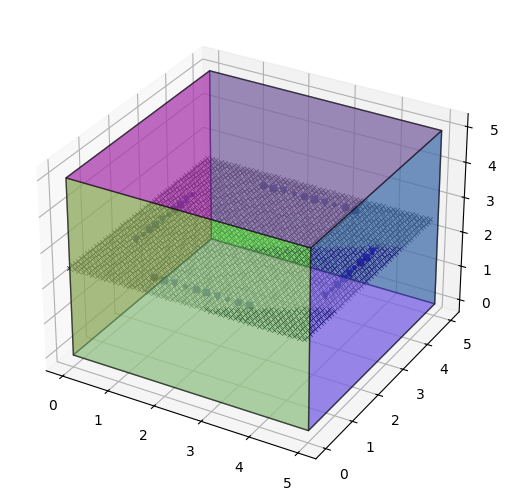

In [ ]:
import numpy as np
import pyroomacoustics as pra
import matplotlib.pyplot as plt
from scipy.linalg import eig

# Setup Anechoic Room to neglect room effects and simplify
fs = 16000
room_dim = [5.0, 5.0, 5.0]
room = pra.ShoeBox(room_dim, fs=fs, max_order=3, air_absorption=True)

# Speaker Setup: A 5-speaker linear array | Pyroomacoustics uses 3D coordinates, so we set Z=0
if False:
    num_speakers = 10
    speaker_x = np.linspace(1.5, 3.5, num_speakers)
    speaker_locs = np.vstack((speaker_x, np.full(num_speakers, 0.5), np.full(num_speakers, 2.5)))

    for loc in speaker_locs.T:
        room.add_source(loc)

if True:
    # Define coordinates for 4 walls (Front, Right, Back, Left)
    num_speakers = 10
    speaker_x = np.linspace(1.5, 3.5, num_speakers)
    speaker_locs_front = np.vstack((speaker_x, np.full(num_speakers, 0.5), np.full(num_speakers, 2.5)))
    speaker_locs_right = np.vstack((np.full(num_speakers, 4.5), speaker_x, np.full(num_speakers, 2.5)))
    speaker_locs_back  = np.vstack((speaker_x, np.full(num_speakers, 4.5), np.full(num_speakers, 2.5)))
    speaker_locs_left  = np.vstack((np.full(num_speakers, 0.5), speaker_x, np.full(num_speakers, 2.5)))

    # Combine all 4 arrays into one master speaker list
    all_speakers = np.hstack((speaker_locs_front, speaker_locs_right, speaker_locs_back, speaker_locs_left))

    # Add all 40 speakers to the room
    for loc in all_speakers.T:
        room.add_source(loc)

# Microphone Grid
spacing = 0.1
x_coords = np.arange(0, 5.0, spacing)
y_coords = np.arange(0, 5.0, spacing)
X, Y = np.meshgrid(x_coords, y_coords)
mics_locs = np.vstack((X.flatten(), Y.flatten(), np.full(X.size, 2.5)))
mic_array = pra.MicrophoneArray(mics_locs, room.fs)
room.add_microphone_array(mic_array)

# Plotting
room.plot()

In [23]:
# Calculate H for a given frequency
info_dict = {500: None, 1000: None}

print('Computing RIR...')
room.compute_rir()

for target_freq in [500, 1000]:

    c = pra.constants.get('c') # Speed of sound
    k = 2 * np.pi * target_freq / c

    # Compute RIR and create empty H
    num_mics = mics_locs.shape[1]
    H = np.zeros((num_mics, num_speakers), dtype=complex)

    # Set FFT params
    nfft = 512 
    freq_bin = int((target_freq / fs) * nfft)

    # Populate H
    print(f'Populating H_{target_freq}...')
    for m in range(num_mics):
        for s in range(num_speakers):
            rir_time_domain = room.rir[m][s]
            h_freq = np.fft.rfft(rir_time_domain, n=nfft)
            H[m, s] = h_freq[freq_bin]

    # Define Bright and Dark Zones by left/right side of the room
    if False:
        bright_indices = np.where(mics_locs[0, :] < 2.5)[0]
        dark_indices = np.where(mics_locs[0, :] >= 2.5)[0]

    # Define the centers and radius for the circular zones
    if True:
        radius = 0.5
        bright_center = np.array([1.5, 3.0])
        dark_center = np.array([3.5, 3.0])
        dist_to_bright = np.sqrt((mics_locs[0, :] - bright_center[0])**2 + (mics_locs[1, :] - bright_center[1])**2)
        dist_to_dark = np.sqrt((mics_locs[0, :] - dark_center[0])**2 + (mics_locs[1, :] - dark_center[1])**2)
        bright_indices = np.where(dist_to_bright <= radius)[0]
        dark_indices = np.where(dist_to_dark <= radius)[0]

    Hb = H[bright_indices, :]
    Hd = H[dark_indices, :]

    # The ACC Math
    lambda_reg = 1e-2 # Regularization to limit "array effort"
    R_dark = Hd.conj().T @ Hd + lambda_reg * np.eye(num_speakers)
    R_bright = Hb.conj().T @ Hb

    # Find the eigenvectors, optimal weights are the eigenvector corresponding to the largest eigenvalue
    vals, vecs = eig(R_bright, R_dark)
    optimal_g = vecs[:, np.argmax(np.real(vals))]

    # Multiply the transfer functions by our optimal speaker weights
    p = H @ optimal_g
    info_dict[target_freq] = {'p': p, 'H': H, 'optimal_g': optimal_g}

Computing RIR...
Populating H_500...
Populating H_1000...


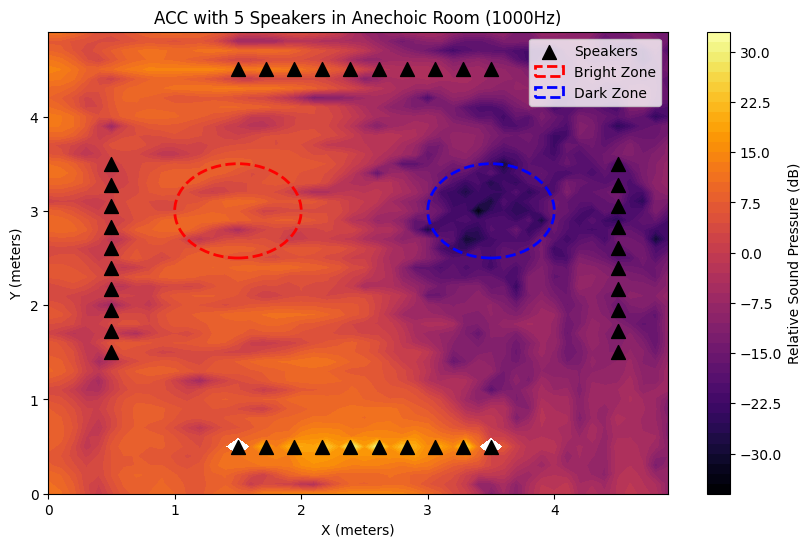

In [24]:

# Extract the complex pressure fields
p500 = info_dict[500]['p']
p1000 = info_dict[1000]['p']

# 1. Calculate the energy (magnitude squared) for each frequency
energy_500 = np.abs(p500)**2
energy_1000 = np.abs(p1000)**2

# 2. Sum the energies and take the square root to get total RMS pressure
p_total_rms = np.sqrt(energy_500 + energy_1000)

# 3. Reshape for the plot
pressure_map = p_total_rms.reshape(X.shape)

# Plotting
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, 20 * np.log10(pressure_map.clip(-80, 40)), levels=50, cmap='inferno')
plt.colorbar(label="Relative Sound Pressure (dB)")

# Overlay speakers and the zone boundary
plt.scatter(all_speakers[0, :], all_speakers[1, :], color='black', label='Speakers', marker='^', s=100)

# Draw the Bright Zone circle (Left)
bright_circle = plt.Circle(bright_center, radius, color='red', fill=False, linestyle='--', linewidth=2, label='Bright Zone')
plt.gca().add_patch(bright_circle)

# Draw the Dark Zone circle (Right)
dark_circle = plt.Circle(dark_center, radius, color='blue', fill=False, linestyle='--', linewidth=2, label='Dark Zone')
plt.gca().add_patch(dark_circle)

# plt.axvline(2.5, color='black', linestyle='--', label='Zone Boundary')

plt.title(f"ACC with 5 Speakers in Anechoic Room ({target_freq}Hz)")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.legend()
plt.show()

In [6]:
import scipy.io.wavfile as wav

# 1. Define the audio properties
duration = 2.0  # seconds
t = np.arange(0, duration, 1/fs)

# 2. Create a fresh room just for listening (saves memory/time)
# We use the same dimensions and properties as your original room
listening_room = pra.ShoeBox(room_dim, fs=fs, max_order=3, air_absorption=True)

# 3. Generate and add the speaker signals using optimal_g
for i in range(num_speakers):
    # Extract volume (magnitude) and delay (phase) from the complex weight
    mag = np.abs(optimal_g[i])
    phase = np.angle(optimal_g[i])
    
    # Create the time-domain sine wave for this specific speaker
    speaker_signal = mag * np.sin(2 * np.pi * target_freq * t + phase)
    
    # Add the speaker to the new room at the original coordinates
    listening_room.add_source(speaker_locs[:, i], signal=speaker_signal)

# 4. Place exactly TWO microphones (The listening points)
# Mic 0 is Bright Center, Mic 1 is Dark Center
listening_mics = np.vstack((bright_center[0], bright_center[1], 2.5))
listening_mics = np.hstack((listening_mics, [[dark_center[0]], [dark_center[1]], [2.5]]))

listening_room.add_microphone_array(pra.MicrophoneArray(listening_mics, listening_room.fs))

# 5. Run the Simulation
print("Simulating audio for playback...")
listening_room.simulate()

# 6. Extract the audio signals
# The signals are usually very quiet or very loud depending on the math, 
# so we normalize them to standard audio levels (-1.0 to 1.0) before saving
bright_audio = listening_room.mic_array.signals[0, :]
dark_audio = listening_room.mic_array.signals[1, :]

# Find the maximum peak across BOTH signals to preserve their relative volume difference
max_val = max(np.max(np.abs(bright_audio)), np.max(np.abs(dark_audio)))
bright_audio_norm = bright_audio / max_val
dark_audio_norm = dark_audio / max_val

# Convert to 16-bit PCM WAV format
bright_wav = np.int16(bright_audio_norm * 32767)
dark_wav = np.int16(dark_audio_norm * 32767)

# 7. Save the files to your current directory
wav.write("bright_zone_center.wav", fs, bright_wav)
wav.write("dark_zone_center.wav", fs, dark_wav)

print("Audio files saved! Go listen to them.")

Simulating audio for playback...
Audio files saved! Go listen to them.
